# Анализ гипотез и проведение A\B-теста

## Оглавление:
* [1. Введение. Описание проекта](#first-bullet)

* [2. Подготовка данных](#second-bullet)
   
* [3. Приоритизация гипотез](#3-bullet)

* [4. Анализ A\B-теста](#4-bullet)
    * [4.1 Оценка выручки](#4.1-bullet)
    * [4.2 Оценка среднего чека](#4.2-bullet)
    * [4.3 Оценка конверсии](#4.3-bullet)
    * [4.4 Оценка количества и стоимости заказов](#4.4-bullet)
    * [4.5 Расчёт показателей статистической значимости](#4.5-bullet)
 
* [5. Выводы и рекомендации](#5-bullet)

## 1. Введение. Описание проекта<a class="anchor" id="first-bullet"></a>

<p style="text-indent: 25px;">Целью проекта является оценка мероприятий, предлагаемых для увеличения выручки. В его результате должно будет выделиться основное мероприятие и дан ответ на вопрос, как оно повлияет на бизнес-показатели. Методическая схема: ранее сформированные гипотезы ранжируются методами ICE и RICE, затем проводятся A\B-тест, анализ и рекомендации для лидирующей гипотезы.<p/>

## 2. Подготовка данных<a class="anchor" id="second-bullet"></a>

<p style="text-indent: 25px;">Входные данные представлены в виде трёх csv-файлов, содержащих информацию об оценке гипотез, сделанных заказах и посещениях сайта. Анализ проводится посредством средств языка Python с использованием сопутствующих библиотек.<p\>
<p style="text-indent: 25px;">Далее представлена подробная информация о входных файлах.<p>

In [1]:
# для анализа будут использоваться python - библиотеки: Pandas, Matplotlib, NumPy, Datetime, Scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns
import numpy as np
import datetime as dt
import scipy.stats as stats

# вывод предупреждений подавлен
import warnings
warnings.filterwarnings("ignore")

In [2]:
# предустановка общих параметров графиков
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
# импорт файлов
hyps = pd.read_csv('/datasets/hypothesis.csv')
ords = pd.read_csv('/datasets/orders.csv')
viss = pd.read_csv('/datasets/visitors.csv')

In [4]:
#функция агрегирования нужной информации о датасете. Реализовано с целью улучшения визуализации информации.
def intro_df(df_name):

    entries_count = pd.DataFrame(df_name.nunique())
    entries_count.columns = ['values_counts']

    columns_types = pd.DataFrame(df_name.dtypes)
    columns_types.columns = ['dtypes']
    columns_types

    entries_count_isnull = pd.DataFrame(df_name.isnull().sum())
    entries_count_isnull.columns = ['isnull_counts']
    entries_count_isnull
    
    entries_max = pd.DataFrame(df_name.max())
    entries_max.columns = ['max']
    entries_max
    
    entries_min = pd.DataFrame(df_name.min())
    entries_min.columns = ['min']
    
    df_name_intro_info = entries_count.join(columns_types)\
                                      .join(entries_count_isnull)\
                                      .join(entries_max)\
                                      .join(entries_min)
    
    df_name.columns = df_name.columns.str.lower().str.replace(' ','_')

    print('Параметры таблицы , (строк, полей):', df_name.shape)
    print('Количество дубликатов:', df_name.duplicated().sum())
    display(df_name_intro_info.transpose())
    print('Первые 3 строки таблицы:')
    display(df_name.head(3))

Файл /datasets/hypothesis.csv:
- hypsothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [5]:
intro_df(hyps)

Параметры таблицы , (строк, полей): (9, 5)
Количество дубликатов: 0


,Hypothesis,Reach,Impact,Confidence,Efforts
values_counts,9,6,7,7,6
dtypes,object,int64,int64,int64,int64
isnull_counts,0,0,0,0,0
max,Показать на главной странице баннеры с актуаль...,10,10,9,10
min,Добавить блоки рекомендаций товаров на сайт ин...,1,1,1,1


Первые 3 строки таблицы:


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


Файл /datasets/orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [6]:
intro_df(ords)

Параметры таблицы , (строк, полей): (1197, 5)
Количество дубликатов: 0


,transactionId,visitorId,date,revenue,group
values_counts,1197,1031,31,713,2
dtypes,int64,int64,object,int64,object
isnull_counts,0,0,0,0,0
max,4293855558,4283872382,2019-08-31,1294500,B
min,1062393,5114589,2019-08-01,50,A


Первые 3 строки таблицы:


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


Файл /datasets/visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [7]:
intro_df(viss)

Параметры таблицы , (строк, полей): (62, 3)
Количество дубликатов: 0


,date,group,visitors
values_counts,31,2,58
dtypes,object,object,int64
isnull_counts,0,0,0
max,2019-08-31,B,770
min,2019-08-01,A,361


Первые 3 строки таблицы:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [8]:
ords['date'] = ords['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
viss['date'] = viss['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

*Вывод по разделу*

<p style="text-indent: 25px;">Данные загружены корректно, пропуски отсутствуют. Поля с датами преобразованы из текстового формата в формат дат. Форматы данных остальных полей соответствуют целевым.<p\>

## 3. Приоритизация гипотез <a class="anchor" id="3-bullet"></a>

In [9]:
# расчёт показателей согласно фреймворков
hyps['ice'] = (hyps['impact'] * hyps['confidence'] / hyps['efforts']).astype('int')
hyps['rice'] = (hyps['reach'] * hyps['impact'] * hyps['confidence'] / hyps['efforts']).astype('int')

# агрегация результатов в датафрейм
hyps_ice = hyps[['hypothesis', 'ice']].sort_values(by = 'ice', ascending = False)
hyps_rice = hyps[['hypothesis', 'rice']].sort_values(by = 'rice', ascending = False)
hyps_comp = pd.merge(hyps_ice, hyps_rice, on = 'hypothesis')
hyps_comp.index += 1

pd.set_option('display.max_colwidth', 150) 
hyps_comp

,hypothesis,ice,rice
1,"Запустить акцию, дающую скидку на товар в день рождения",16,16
2,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13,40
3,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11,112
4,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8,40
5,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7,56
6,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1,9
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1,3
9,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1,4


*Вывод по разделу*
<p style="text-indent: 25px;">Применённые фреймворки показали разные результаты. Лидеры ICE - гипотезы №№ 1,2,3, выбор RICE - гипотезы №№ 3,5,2 и 4. Разница возникает из-за эффекта охвата аудитории, т.к. высокоранжируемые RICE гипотезы будут влиять на всех пользователей сайта магазина.<p\>
<p style="text-indent: 25px;">Таким образом, в связи со свободным ресурсом разработки, к проверке предлагается лидирующая гипотеза - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".<p\>

## 4. Анализ A\B-теста<a class="anchor" id="4-bullet"></a>

#### 4.1 Оценка кумулятивной выручки <a class="anchor" id="4.1-bullet"></a>

In [10]:
# создание массива уникальных значений дат и групп
grs = ords[['date','group']].drop_duplicates()

# агрегирование кумулятивных данных по выручке относительно дат проведения теста
ords_agg = grs.apply(
                    lambda x: ords[np.logical_and(ords['date'] <= x['date'],
                              ords['group'] == x['group'])]
                             .agg(
                             {'date': 'max', 
                             'group': 'max', 
                             'transactionid': pd.Series.nunique, 
                             'visitorid':pd.Series.nunique,
                             'revenue': 'sum'}
                    )
                     , axis = 1)\
            .sort_values(by = ['date', 'group'])

# агрегирование кумулятивных данных по кол-ву посетителей относительно дат проведения теста
viss_agg = grs.apply(
                    lambda x: viss[np.logical_and(viss['date'] <= x['date'],
                              viss['group'] == x['group'])]
                             .agg(
                             {'date': 'max', 
                             'group': 'max', 
                             'visitors':'sum'}
                    )
                     , axis = 1)\
            .sort_values(by = ['date', 'group'])

# объединение данных о выручке и количеству посетителей, переименование полей
cum_agg = ords_agg.merge(
                        viss_agg,
                        left_on = ['date', 'group'], 
                        right_on = ['date', 'group'])

cum_agg.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

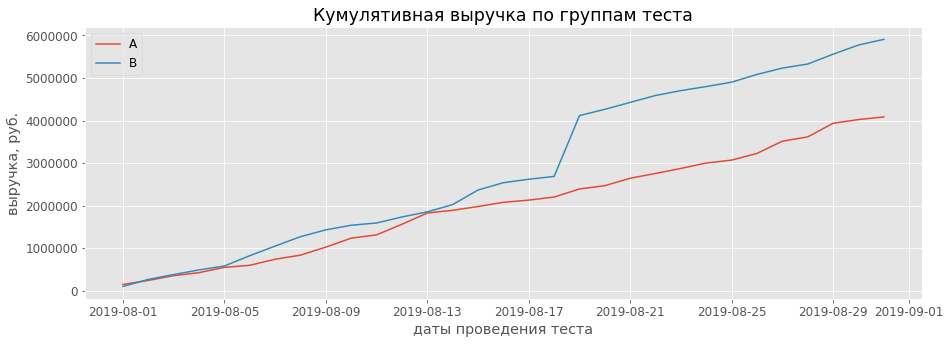

In [11]:
# построение графика кум-ой выручки для группы А
cum_agg_A = cum_agg[cum_agg['group'] == 'A'][['date', 'revenue', 'orders']]
plt.plot(cum_agg_A['date'], cum_agg_A['revenue'], label = 'A')

# построение графика кум-ой выручки для группы B
cum_agg_B = cum_agg[cum_agg['group'] == 'B'][['date', 'revenue', 'orders']]
plt.plot(cum_agg_B['date'], cum_agg_B['revenue'], label = 'B')

plt.title('Кумулятивная выручка по группам теста')
plt.xlabel('даты проведения теста')
plt.ylabel('выручка, руб.')
plt.legend()
plt.show()

<p style="text-indent: 25px;">Визуальная оценка графика говорит о равномерном увеличении выручки в течение теста по обеим группам. При этом 13.08.19 группа В увеличивает темпы роста, 18.08.19 происходит резкий рост показателя для этой группы и новый, более высокий, уровень сохраняется до конца теста. В этой связи, важно исследовать влияние аномалий в виде случайных заказов с параметрами значительно выше среднего.<p\>

#### 4.2 Оценка среднего чека <a class="anchor" id="4.2-bullet"></a>

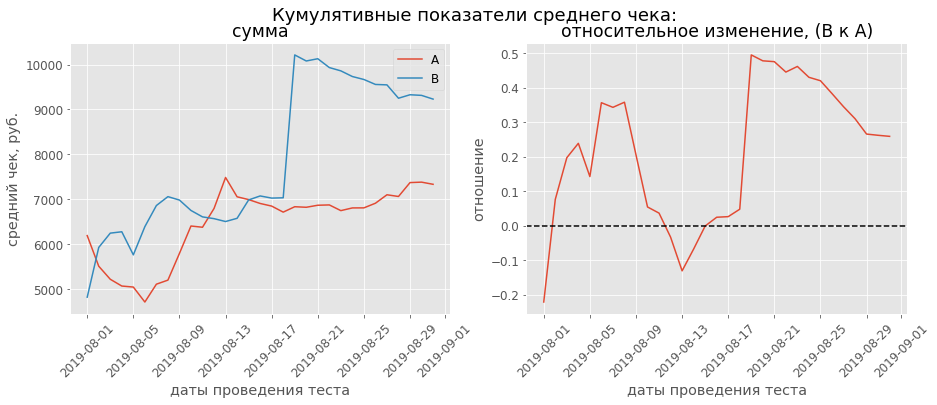

In [12]:
# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Кумулятивные показатели среднего чека:', fontsize=18)

# построение графиков средних чеков по группа. Величина чека определяется как подневное
# отношение выручки к количеству заказов.
ax[0].plot(cum_agg_A['date'], 
           cum_agg_A['revenue'] / cum_agg_A['orders'],
           label = 'A')
ax[0].plot(cum_agg_B['date'], 
           cum_agg_B['revenue'] / cum_agg_B['orders'], 
           label = 'B')

ax[0].set_title('сумма')
ax[0].set_xlabel('даты проведения теста')
ax[0].set_ylabel('средний чек, руб.')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)


# построение графика относительного отличия среднего чека

# подготовка данных, объединение данных по обеим группам
cum_agg_AB = cum_agg_A.merge(
                             cum_agg_B, 
                             left_on = 'date', 
                             right_on = 'date', 
                             suffixes = ['A', 'B']
                             )
# построение графика с маркерной горизонтальной осью
ax[1].plot(
         cum_agg_AB['date'],
         (cum_agg_AB['revenueB'] / cum_agg_AB['ordersB']) / 
         (cum_agg_AB['revenueA'] / cum_agg_AB['ordersA']) - 1
          )

ax[1].axhline(y=0, color='black', linestyle='--')

ax[1].set_title('относительное изменение, (B к A)')
ax[1].set_xlabel('даты проведения теста')
ax[1].set_ylabel('отношение')
ax[1].tick_params(axis='x', rotation=45)

plt.show()

<p style="text-indent: 25px;">Средние чеки выросли по обеим группам. Явление, отмеченное при оценке выручки, а именно резкое ускорение темпов прироста показателя для группы B, <font color="blue">начиная с 18.08.19, отмечается и для среднего чека. При этом группа A стагнирует на одном уровне. </font> <p\>
<p style="text-indent: 25px;">Оценка относительного изменения средних чеков между группами показывает два пика: 6-7 августа, когда разница составляла 35%, и 18 августа, когда разница достигла 50%.<p\>
<p style="text-indent: 25px;">Таким образом, можно предпложить, что опережающий рост выручки для группы B связан с одной или несколькими большими покупками в вышеуказанные даты. Анализ статистических выбросов будет проведён в одном из последующих разделов настоящего исследования.<p\>

#### 4.3 Оценка конверсии <a class="anchor" id="4.3-bullet"></a>

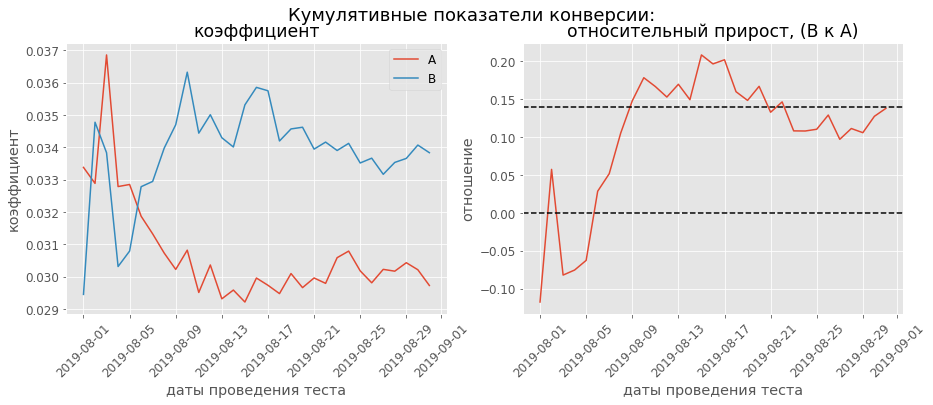

In [13]:
# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Кумулятивные показатели конверсии:', fontsize=18)

# расчёт кумулятивной конверсии в целом и по группам теста
cum_agg['conv'] = cum_agg['orders'] / cum_agg['visitors']
cum_agg_A = cum_agg[cum_agg['group'] == 'A']
cum_agg_B = cum_agg[cum_agg['group'] == 'B']

# построение графиков кумулятивной конверсии по группам
ax[0].plot(cum_agg_A['date'], 
           cum_agg_A['conv'],
           label = 'A')
ax[0].plot(cum_agg_B['date'], 
           cum_agg_B['conv'], 
           label = 'B')

ax[0].set_title('коэффициент')
ax[0].set_xlabel('даты проведения теста')
ax[0].set_ylabel('коэффициент')
ax[0].legend()
ax[0].tick_params(axis='x', rotation=45)


# построение графика относительных отличий кумулятивных конверсий

# подготовка данных, объединение данных по обеим группам
cum_agg_AB = cum_agg_A[['date', 'conv']].merge(
                             cum_agg_B[['date', 'conv']], 
                             left_on = 'date', 
                             right_on = 'date', 
                             suffixes = ['A', 'B']
                             )
# построение графика с маркерной горизонтальной осью
ax[1].plot(
         cum_agg_AB['date'],
         cum_agg_AB['convB'] / cum_agg_AB['convA'] - 1
          )

ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].axhline(y=0.14, color='black', linestyle='--')

ax[1].set_title('относительный прирост, (B к A)')
ax[1].set_xlabel('даты проведения теста')
ax[1].set_ylabel('отношение')
ax[1].tick_params(axis='x', rotation=45)

plt.show()


<p style="text-indent: 25px;">После значительных колебаний в начале проведения теста по обеим группам и последующего разнонаправленного движения - для группы A снижение конверсии, а для B - резкий рост, отмечается балансировка коэффициента конверсии на уровне 3,4% для группы B и меньшее, 3% значение, для группы A.<p\>
<p style="text-indent: 25px;">График относительного изменения конверсий показывает уверенное превышение показателя в группе B над группой A. На дату фиксации результатов теста разница составила 14%.<p\>

#### 4.4 Оценка количества и стоимости заказов <a class="anchor" id="4.4-bullet"></a>

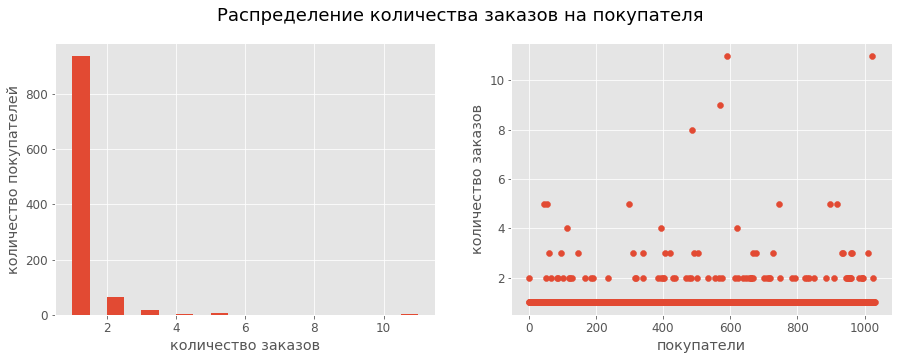

Дополнительные показатели распределения количества заказов на покупателя:
95-й перцентиль - 2 заказа;
99-й перцентиль - 4 заказа.

Критерий Шапиро-Уилка: p-value - 0.0000%; statistic - 22.6848%.
Распределение не нормально.


In [14]:
# группировка количества заказов по пользователям
ords_vis = ords.groupby('visitorid', as_index = False)\
                .agg({'transactionid': pd.Series.nunique})

ords_vis.columns = ['id', 'ords_num']

# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Распределение количества заказов на покупателя', fontsize=18)

# построение гистограммы распределения заказов в расчёте на одного пользователя
ax[0].hist(ords_vis['ords_num'], bins=20)
ax[0].set_xlabel('количество заказов')
ax[0].set_ylabel('количество покупателей')

# построение точечной гистограммы распределения заказов в расчёте на одного пользователя
x_values = pd.Series(range(0, len(ords_vis)))
ax[1].scatter(x_values, ords_vis['ords_num'])
ax[1].set_xlabel('покупатели')
ax[1].set_ylabel('количество заказов')
plt.show()

# расчёт перцентилей для определения уровня статистических выбросов
pers = np.percentile(ords_vis['ords_num'], [95, 99])
print('Дополнительные показатели распределения количества заказов на покупателя:')
print('95-й перцентиль - {:.0f} заказа;'.format(pers[0]))
print('99-й перцентиль - {:.0f} заказа.'.format(pers[1]))
print()
# проверка распределения количества заказов на нормальность
ord_norm = stats.shapiro(ords_vis['ords_num'])
print('Критерий Шапиро-Уилка: p-value - {:.4%}; statistic - {:.4%}.'.format(ord_norm[1], ord_norm[0]))

if (ord_norm[1] < 0.05): print("Распределение не нормально.")
else: print("Распределение нормально.")

<p style="text-indent: 25px;">Визуальная оценка графиков показывает наличие выбросов в диапазоне 4-11 заказов. Расчёт долевых показателей распределения покупателей показывает, что только 1% из них делали 4 и более заказов. <p\>
<p style="text-indent: 25px;">Таким образом, уровнем статистических выбросов можно уверенно считать 4 заказа на покупателя. <p\>

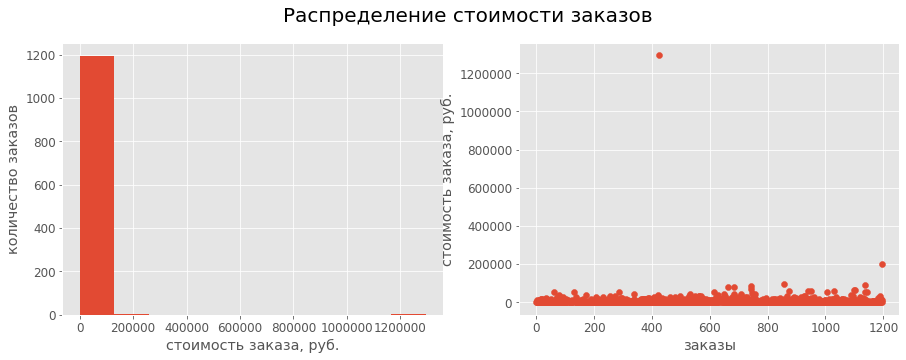

Дополнительные показатели распределения стоимости заказов:
95-й перцентиль - 28000 руб.;
99-й перцентиль - 58233 руб.

Критерий Шапиро-Уилка: p-value - 0.0000%; statistic - 10.3454%.
Распределение не нормально.


In [15]:
# определение параметров фигуры для вывода двух графиков в одной строке
fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Распределение стоимости заказов', fontsize=20)

# построение гистограммы распределения заказов в расчёте на одного пользователя
ax[0].hist(ords['revenue'])
ax[0].set_xlabel('стоимость заказа, руб.')
ax[0].set_ylabel('количество заказов')

# построение точечной гистограммы распределения заказов в расчёте на одного пользователя
x_values = pd.Series(range(0, len(ords)))
ax[1].scatter(x_values, ords['revenue'], )
ax[1].set_xlabel('заказы')
ax[1].set_ylabel('стоимость заказа, руб.')
plt.show()

# расчёт перцентилей для определения уровня статистических выбросов
pers = np.percentile(ords['revenue'], [95, 99])
print('Дополнительные показатели распределения стоимости заказов:')
print('95-й перцентиль - {:.0f} руб.;'.format(pers[0]))
print('99-й перцентиль - {:.0f} руб.'.format(pers[1]))
print()
# проверка распределения стоимости заказов на нормальность
rev_norm = stats.shapiro(ords['revenue'])
print('Критерий Шапиро-Уилка: p-value - {:.4%}; statistic - {:.4%}.'.format(rev_norm[1], rev_norm[0]))

if (rev_norm[1] < 0.05): print("Распределение не нормально.")
else: print("Распределение нормально.")   

<p style="text-indent: 25px;">Визуальная оценка графиков показывает две значительные аномалии с суммами 200 и более 1200 тыс. руб., которые оказали значительное влияние на стоимостные характеристики теста. При этом отмечается неопределённость в оценке влияния заказов менее 200 т.р., т.к. в этом ареале график носит разреженный характер. Расчёт долевых показателей распределения стоимости заказов показывает, что только 1% покупателей делали заказы на сумму более 58 тыс. руб. <p\>
<p style="text-indent: 25px;">Таким образом, уровнем статистических выбросов можно уверенно принять сумму 58 тыс. руб. за заказ. <p\>

#### 4.5 Расчёт показателей статистической значимости <a class="anchor" id="4.5-bullet"></a>

*Формулировка гипотез*
<p style="text-indent: 25px;"> В рамках настоящего исследования необходимо провести оценку статистической значимости конверсии и среднего чека. С этой целью формулируются две пары гипотез(H0 - нулевая, H1 - альтернативная) для последующей проверки.</p>
<p style="text-indent: 25px;"> Конверсия. H0: "Статистические значимые отличия в конверсии групп А и В отсутствуют", H1: "Есть статистические значимые отличия в конверсии групп А и В."</p>
<p style="text-indent: 25px;"> Средний чек. H0: "Статистические значимые отличия в сумме среднего чека групп А и В отсутствуют", H1: "Есть статистические значимые отличия в сумме среднего чека групп А и В."</p>

*Параметры проверки гипотез*
<p style="text-indent: 25px;"> В связи с тем, что распределения оцениваемых величин являются ненормальными и представлены толькое две выборки, которые являются независимыми, то оценка возможных различий в поведении групп теста будет проводится с помощью статистического критерия Манна-Уитни посредством библиотеки Scipy.stats.<p\> 
<p style="text-indent: 25px;"> Учитывая отсутствие информации об особом характере изучаемых данных, критический уровень статистической значимости будет установлен как 0.05.<p\>

In [16]:
# подготовка данных

# определение подневного и кумулятивное кол-ва посетителей в группе A
visrs_day_A = viss_agg[viss_agg['group'] == 'A'][['date', 'visitors']]
visrs_day_A.columns = ['date', 'visrs_day_A']
visrs_cum_A = visrs_day_A.apply(
                                lambda x: visrs_day_A[visrs_day_A['date'] <= x['date']].
                                          agg({'date': 'max', 'visrs_day_A': 'sum'}),
                                axis = 1
                                )
visrs_cum_A.columns = ['date', 'visrs_cum_A']

# определение подневного и кумулятивное кол-ва посетителей в группе B
visrs_day_B = viss_agg[viss_agg['group'] == 'B'][['date', 'visitors']]
visrs_day_B.columns = ['date', 'visrs_day_B']
visrs_cum_B = visrs_day_B.apply(
                                lambda x: visrs_day_B[visrs_day_B['date'] <= x['date']].
                                          agg({'date': 'max', 'visrs_day_B': 'sum'})
                                ,axis = 1
                                )
visrs_cum_B.columns = ['date', 'visrs_cum_B']

# определение подневных и кумулятивных кол-ва заказов и выручки для группы A
ords_day_A = ords[ords['group'] == 'A'][['date','transactionid','visitorid','revenue']]\
             .groupby('date', as_index = False)\
             .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
ords_day_A.columns = ['date', 'ords_day_A', 'rev_day_A']

ords_cum_A = ords_day_A.apply(
                                lambda x: ords_day_A[ords_day_A['date'] <= x['date']]
                                          .agg({
                                              'date': 'max',
                                              'ords_day_A': 'sum',
                                              'rev_day_A': 'sum'
                                               })
                                ,axis = 1
                                )\
                                .sort_values(by = 'date')
ords_cum_A.columns = ['date', 'ordrs_cum_A', 'rev_cum_A']

# определение подневных и кумулятивных кол-ва заказов и выручки для группы B
ords_day_B = ords[ords['group'] == 'B'][['date','transactionid','visitorid','revenue']]\
              .groupby('date', as_index = False)\
              .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
ords_day_B.columns = ['date', 'ords_day_B', 'rev_day_B']

ords_cum_B = ords_day_B.apply(
                                lambda x: ords_day_B[ords_day_B['date'] <= x['date']]
                                          .agg({
                                              'date': 'max',
                                              'ords_day_B': 'sum',
                                              'rev_day_B': 'sum'
                                               })
                                ,axis = 1
                                )\
                                .sort_values(by = 'date')
ords_cum_B.columns = ['date', 'ordrs_cum_B', 'rev_cum_B']

# объединение подневных и кумулятивных данных кол-ва посетителей, заказов и выручки
rep = ords_day_A.merge(ords_day_B, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(ords_cum_A, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(ords_cum_B, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(visrs_day_A, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(visrs_day_B, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(visrs_cum_A, left_on = 'date', right_on = 'date', how = 'left')\
                .merge(visrs_cum_B, left_on = 'date', right_on = 'date', how = 'left')


In [17]:
# расчёт статистической значимости в конверсии и среднем чеке до отделения выбросов

# определение количества заказов по покупателям
ords_vis_A = ords[ords['group'] == 'A'].groupby('visitorid', as_index = False)\
                                         .agg({'transactionid': pd.Series.nunique})
ords_vis_A.columns = ['visitorid', 'ords_num']


ords_vis_B = ords[ords['group'] == 'B'].groupby('visitorid', as_index = False)\
                                       .agg({'transactionid': pd.Series.nunique})
ords_vis_B.columns = ['visitorid', 'ords_num']

# формирование списка количества заказов для каждого из посетителей по группам
con_A = pd.concat([ords_vis_A['ords_num'],
               pd.Series(0, index=np.arange(rep['visrs_day_A'].sum()
             - len(ords_vis_A['ords_num'])), name='ords_num')], axis = 0)
con_B = pd.concat([ords_vis_B['ords_num'], 
               pd.Series(0, index=np.arange(rep['visrs_day_B'].sum()
             - len(ords_vis_B['ords_num'])), name='ords_num')], axis = 0)

print('Оценка статистической значимости параметров до отделения статистических выбросов:')
print()
# применение критерия Манна-Уитни для конверсии
print('а) конверсия:')
print('- критерий Манна-Уитни: {0:.3f};'.format(stats.mannwhitneyu(con_A, con_B)[1]))

# расчёт относительного отличия в конверсии
print('- относительное отличие между группами: {:.0%}.'.format(con_B.mean() / con_A.mean() - 1))

print()
print('б) средний чек:')
# применение критерия Манна-Уитни для среднего чека
print('- критерий Манна-Уитни: {0:.3f};'.format\
                        (stats.mannwhitneyu
                        (ords[ords['group'] == 'B']['revenue'], ords[ords['group'] == 'A']['revenue'])
                         [1]))
# расчёт относительного отличия в среднем чеке
print('- относительное отличие между группами: {:.0%}.'.format\
                        (ords[ords['group'] == 'B']['revenue'].mean() /
                        ords[ords['group'] == 'A']['revenue'].mean() - 1))

Оценка статистической значимости параметров до отделения статистических выбросов:

а) конверсия:
- критерий Манна-Уитни: 0.007;
- относительное отличие между группами: 14%.

б) средний чек:
- критерий Манна-Уитни: 0.365;
- относительное отличие между группами: 26%.


<p style="text-indent: 25px;">P-value конверсий по тесту Манна-Уитни составил 0,007, что менее принятого критерия статистической значимости 0,05. Соответственно, можно отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в конверсии. Данное предоположение подтверждает относительное отличие конверсии, которое показывает 6% преимущество группы B.<p\>
<p style="text-indent: 25px;">Сравнение средних чеков по тесту Манна-Уитни позволяет не отвергать нулевую гипотезу об отсутствии статистически значимых различий между средними чеками групп (p-value = 0,365). Теме не менее, группа B имеет значительное 26% относительное преимущество в сумме среднего чека.<p\>
<p style="text-indent: 25px;">Таким образом, учитывая полученные данные, можно предположить, что на показатель среднего чека оказывают влияние аномалии, выявленные в предыдущих разделах исследования. В этой связи будет произведена повторная оценка статистической значимости параметров после удаления аномальных значений.<p\>
<p style="text-indent: 25px;">Критерии аномальных значений:<p\>
     а) количество заказов - 4 и более;<br>
     б) сумма заказа - более 58 тыс. руб.

In [18]:
# определение количества аномальных покупателей
id_ords_many = pd.concat([ords_vis_A[ords_vis_A['ords_num'] > 4]['visitorid'],
                        ords_vis_A[ords_vis_B['ords_num'] > 4]['visitorid']],
                        axis = 0)
id_ords_exp = ords[ords['revenue'] > 58000]['visitorid']

ords_out = pd.concat([id_ords_many, id_ords_exp], axis = 0).drop_duplicates()
print_ords_out = ords_out.count() # доп.переменная для устанения ошибки чтения формата методом isin() в след.блоке
print('Количество покупателей с аномальными заказами - {:.0f}.'.format(print_ords_out))
print('Доля покупателей с аномальными заказами в общем количестве покупателей - {:.1%}.'.format\
                        (print_ords_out/(ords_vis['id'].count())))

Количество покупателей с аномальными заказами - 17.
Доля покупателей с аномальными заказами в общем количестве покупателей - 1.6%.


<p style="text-indent: 25px;">Удаление данного количества покупателей позволит оставить репрезентативную выборку.<p\>


In [19]:
# формирование списка количества заказов для каждого из посетителей по группам без аномалий
con_A_out = pd.concat([ords_vis_A[np.logical_not(ords_vis_A['visitorid'].isin(ords_out))]['ords_num'],
               pd.Series(0, index=np.arange(rep['visrs_day_A'].sum()
             - len(ords_vis_A['ords_num'])), name='ords_num')], axis = 0)
con_B_out = pd.concat([ords_vis_B[np.logical_not(ords_vis_B['visitorid'].isin(ords_out))]['ords_num'], 
               pd.Series(0, index=np.arange(rep['visrs_day_B'].sum()
             - len(ords_vis_B['ords_num'])), name='ords_num')], axis = 0)

print('Оценка статистической значимости параметров после отделения статистических выбросов:')
print()
# применение критерия Манна-Уитни для конверсии
print('а) конверсия:')
print('- критерий Манна-Уитни: {0:.3f};'.format(stats.mannwhitneyu(con_A_out, con_B_out)[1]))

# расчёт относительного отличия в конверсии
print('- относительное отличие между группами: {:.0%}.'.format(con_B_out.mean() / con_A_out.mean() - 1))
print()
print('б) средний чек:')
# применение критерия Манна-Уитни для среднего чека
print('- критерий Манна-Уитни: {0:.3f};'.format\
                (stats.mannwhitneyu
                (ords[np.logical_and(ords['group'] == 'B', 
                                     np.logical_not(ords['visitorid'].isin(ords_out)))]
                                             ['revenue'], 
                ords[np.logical_and(ords['group'] == 'A', 
                                     np.logical_not(ords['visitorid'].isin(ords_out)))]
                                             ['revenue'])
                [1]))
# расчёт относительного отличия в среднем чеке
print('- относительное отличие между группами: {:.0%}.'.format\
                        (ords[np.logical_and(ords['group'] == 'B', 
                                     np.logical_not(ords['visitorid'].isin(ords_out)))]
                                             ['revenue'].mean() /
                        ords[np.logical_and(ords['group'] == 'A', 
                                     np.logical_not(ords['visitorid'].isin(ords_out)))]
                                             ['revenue'].mean() - 1))

Оценка статистической значимости параметров после отделения статистических выбросов:

а) конверсия:
- критерий Манна-Уитни: 0.005;
- относительное отличие между группами: 16%.

б) средний чек:
- критерий Манна-Уитни: 0.395;
- относительное отличие между группами: 1%.


<p style="text-indent: 25px;">Таким образом, для конверсии принимается альтернативная гипотеза H1 "Есть статистические значимые отличия в конверсии групп А и В." с p-value равным 0.005; для среднего чека принимается нулевая гипотеза H0 "Статистические значимые отличия в сумме среднего чека групп А и В отсутствуют" с p-value равным 0.395.<p\>
<p style="text-indent: 25px;">Из приведённых выше данных следует, что рост выручки был обеспечен за счёт лучшей на 16% конверсии в группе В. Средний чек не оказал значимого влияния на выручки и его разные для каждой группы значения были обусловлены аномальными покупками.<p\>

## 5. Выводы и рекомендации  <a class="anchor" id="5-bullet"></a>

*Выводы*
<p style="text-indent: 25px;"> Таким образом, в связи со свободным ресурсом разработки, проводилась проверка лидирующей по фреймворку RICE гипотеза - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". На основании собранной базы была организована email-рассылка и проведён A\B - тест. </p>
<p style="text-indent: 25px;"> Тест проводился в период 01.08.19 - 31.08.19. Было выявлено, что выручка увеличивалась по обоим контрольным группам, однако группа B с кумулятивной выручкой 6 млн. руб. против 4 млн. руб. у группы A показала опережающую динамику. </p>
<p style="text-indent: 25px;"> По результатам анализа конверсии и среднего чека с использованием критерия Манна-Уитни было определено, что сумма покупок является одинаковой для обеих групп: p-value - 0,395, относительное отличие - 1%. Влияние на опережающий рост выручки оказала значительно выросшая конверсия: p-value - 0,005, относительное отличие - 16% .</p>

*Рекомендации*
<p style="text-indent: 25px;">Учитывая устоявшийся характер динамики показателей и достижение целевого размера выборки, предлагается признать тест состоявшимся и прекратить его проведение. В качестве основного результа определить, что между группами имеется статистическое отличие, а именно - конверсия группы B на 16% больше, чем у группы A. </font> Примененные к группе B изменения рекомендованы к внедрению в промышленную эксплуатацию без ограничений.</p>